In [2]:
import gc
import time
import numpy as np
import pandas as pd 
from scipy.sparse import csr_matrix, hstack

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import lightgbm as lgb

import sys
import wordbatch

from wordbatch.extractors import WordBag, WordHash
from wordbatch.models import FTRL, FM_FTRL

from nltk.corpus import stopwords
import re

In [4]:
train = pd.read_table('/home/yvaska/Desktop/Mercadi/train/train.tsv', engine='c', dtype={'text': unicode})
test = pd.read_table('/home/yvaska/Desktop/Mercadi/test/test.tsv', engine='c')

In [3]:
#train= train[:5000]

In [5]:
print train.dtypes
print "shape of the data:",train.shape

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object
shape of the data: (1482535, 8)


In [6]:
print train.isnull().sum()
train.head()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


2009.0
0.0


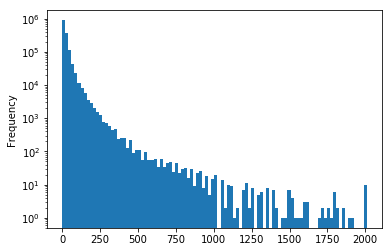

In [8]:
max_price=train['price'].max()
print max_price
min_price=train['price'].min()
print min_price
#train['price'].plot(bins=np.logspace(0, np.log(max_price), 100), kind='hist', loglog=True, xlim=(0,max_price))
train['price'].plot(bins=100, kind='hist', log=True)

In [9]:
print len(train[(train['price']==0)])
train = train.drop(train[(train['price'] ==0)].index)

874


In [10]:
merged = pd.concat([train, test], 0, ignore_index = True)

In [11]:
merged["brand_name"]        = merged["brand_name"].fillna("Missing")
merged['category_name']     = merged['category_name'].fillna("Missing/Missing/Missing")
merged["item_description"]  = merged["item_description"].fillna("Missing")

In [12]:

merged['Main_Category'], merged['Sub_Category1'], merged['Sub_Category2'] = zip(*merged['category_name'].apply(lambda x: x.split("/")))


In [10]:
del [merged['category_name']]
merged.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,Main_Category,Sub_Category1,Sub_Category2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Missing,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Missing,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [11]:
merged.isnull().sum()

train_id             0
name                 0
item_condition_id    0
brand_name           0
price                0
shipping             0
item_description     0
Main_Category        0
Sub_Category1        0
Sub_Category2        0
dtype: int64

In [12]:
merged['Main_Category'] = merged['Main_Category'].astype('category')
merged['Sub_Category1'] = merged['Sub_Category1'].astype('category')
merged['Sub_Category2'] = merged['Sub_Category2'].astype('category')
merged['item_condition_id'] = merged['item_condition_id'].astype('category') 
print train.dtypes

train_id                int64
name                   object
item_condition_id    category
brand_name             object
price                 float64
shipping                int64
item_description       object
Main_Category        category
Sub_Category1        category
Sub_Category2        category
dtype: object


In [ ]:
merged['item_condition_id'] = scipy.sparse.csr_matrix(pd.get_dummies(merged[["item_condition_id"]], sparse = True).values)
merged['shipping'] = scipy.sparse.csr_matrix(pd.get_dummies(train[["shipping"]], sparse = True).values)

In [13]:
print "Unique items in  Main Categories:",train['Main_Category'].nunique()
print "Unique items in Sub Category 1  :",train['Sub_Category1'].nunique()
print "Unique items in Sub Category 2  :", train['Sub_Category2'].nunique()
print "Unique items in Brand Names     :", train['brand_name'].nunique()
print "Unique items in Names     :", train['name'].nunique()

Unique items in  Main Categories: 9
Unique items in Sub Category 1  : 25
Unique items in Sub Category 2  : 37
Unique items in Brand Names     : 30
Unique items in Names     : 50


In [14]:
#wb_desc = wordbatch.WordBatch(None, extractor=(WordBag, {"hash_ngrams": 2, "hash_ngrams_weights": [1.0, 1.0],"hash_size": 2 ** 28, "norm": "l2", "tf": 1.0,"idf": None}), procs=8)

#wb_desc.dictionary_freeze = True
wb= wordbatch.WordBatch(extractor=(WordBag, {"hash_ngrams":2, "hash_ngrams_weights":[1.0, 1.0], "hash_size":2**28, "norm":'l2', "tf":1.0, "idf":None}))
wb.dictionary_freeze = True
X_desc = wb.fit_transform(merged['item_description'])
print X_desc.shape

Normalize text
Extract wordbags
(50, 268435456)


In [15]:
# Word Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse
count_vectorizer = CountVectorizer()
X_name = count_vectorizer.fit_transform(train['name'])
X_main_Cat = count_vectorizer.fit_transform(train['Main_Category'])
X_sub_Cat1 = count_vectorizer.fit_transform(train['Sub_Category1'])
X_sub_Cat2 = count_vectorizer.fit_transform(train['Sub_Category2'])
# analyze = count_vectorizer.build_analyzer()
# print count_vectorizer.vocabulary_.get("great")
X_dummies = scipy.sparse.csr_matrix(pd.get_dummies(train[["item_condition_id", "shipping"]], sparse = True).values)

In [16]:
X = hstack((X_desc,X_name,X_sub_Cat1,X_main_Cat,X_sub_Cat2,X_dummies), dtype=np.float32).tocsr()
print X.shape

(50, 268435756)


In [17]:
from sklearn.externals import joblib
filename = '/home/yvaska/Desktop/Mercadi/matrix.sav'
joblib.dump(X, filename)
#X = joblib.load(filename)


['/home/yvaska/Desktop/Mercadi/matrix.sav']

In [18]:
row_count = train.shape[0]
split_point = int(row_count*.75)
X_train, X_test = X[:split_point], X[split_point:]
Y_train, Y_test = train['price'][:split_point], train['price'][split_point:]


In [19]:
X_train.shape

(37, 268435756)

In [ ]:
##Ridge_Model
from sklearn.linear_model import Ridge
ridge_model_with_CV = Ridge(solver='auto', fit_intercept=True, alpha=0.5,max_iter=100, normalize=False, tol=0.05,)
ridge_model_V1 = Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=None, solver='auto', tol=0.001)
ridge_model_V1.fit(X_train,Y_train)

In [ ]:
# Tfidf Vectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
#tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df = 0, stop_words = 'english')
# ###vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
#tfidf_matrix =  tf.fit_transform(train_new['item_description'])
# print tfidf_matrix.shape
###print tf.get_feature_names()

In [ ]:
### HashVectorizer
# from sklearn.feature_extraction.text import HashingVectorizer
# vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False, n_features=opts.n_features)
# X_train = vectorizer.transform(train_new['item_description'])
###hv = HashingVectorizer()
###hv.transform(new['item_description'])

In [ ]:
MAX_NAME_SEQ = 10 #17
MAX_ITEM_DESC_SEQ = 75 #269
MAX_CATEGORY_SEQ = 8 #8
MAX_TEXT = np.max([np.max(full_df.seq_name.max()), np.max(full_df.seq_item_description.max())]) + 100
MAX_CATEGORY = np.max(full_df.category.max()) + 1
MAX_BRAND = np.max(full_df.brand_name.max()) + 1
MAX_CONDITION = np.max(full_df.item_condition_id.max()) + 1
MAX_DESC_LEN = np.max(full_df.desc_len.max()) + 1
MAX_NAME_LEN = np.max(full_df.name_len.max()) + 1
MAX_SUBCAT_0 = np.max(full_df.subcat_0.max()) + 1
MAX_SUBCAT_1 = np.max(full_df.subcat_1.max()) + 1
MAX_SUBCAT_2 = np.max(full_df.subcat_2.max()) + 1
